In [654]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from google.colab import drive

In [655]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [656]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Data/heart_attack_prediction_dataset.csv"

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=2)

heart_attack = pd.read_csv(file_path)

heart_attack.head()


,Age,Sex,Cholesterol,Blood Pressure,Heart Attack Risk,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,67,Male,208,158,0,72,0,0,1,0,...,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere
1,21,Male,389,165,0,98,1,1,1,1,...,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere
2,21,Female,324,174,0,72,1,0,0,0,...,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere
3,84,Male,383,163,0,73,1,1,1,0,...,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere
4,66,Male,318,91,0,93,1,1,1,1,...,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere


In [657]:
#Defining mapping function to map multiple inputs of the dataset
def gender_map(x):
    return x.map({'M': 1, 'F': 0, 'Male' : 1, "Female" : 0, '1' : 1, '0' : 0})

def hemisphere_map(x):
    return x.map({'Southern Hemisphere' : -1, 'Northern Hemisphere' : 1})

def countries_map(x):
    return x.map({'Argentina' : -1, 'Brazil' : -1, 'China' : -1, 'Colombia' : -1,
    'India' : -1, 'Nigeria' : -1, 'South Africa' : -1, 'South Korea' : -1, 'Thailand' : -1,
    'Vietnam' : -1, 'Australia' : 1, 'Canada' : 1, 'France' : 1, 'Germany' : 1,
    'Italy' : 1, 'Japan' : 1, 'New Zealand' : 1, 'Spain' : 1, 'United Kingdom' : 1,
    'United States' : 1})

def diet_map(x):
    return x.map({'Unhealthy' : -1, 'Average' : 0, 'Healthy' : 1})

def continent_map(x):
    return x.map({'Asia' : 0, 'Africa' : 1, 'Europe' : 2, 'North America' : 3,
    'South America' : 4, 'Australia' : 5})

In [658]:
heart_attack['Sex'] = heart_attack[['Sex']].apply(gender_map)
heart_attack['Hemisphere'] = heart_attack[['Hemisphere']].apply(hemisphere_map)
heart_attack['Country'] = heart_attack[['Country']].apply(countries_map)
heart_attack['Diet'] = heart_attack[['Diet']].apply(diet_map)
heart_attack['Continent'] = heart_attack[['Continent']].apply(continent_map)

unique_sex = heart_attack['Sex'].unique()
print(unique_sex)
unique = heart_attack['Hemisphere'].unique()
print(unique)
unique_country = heart_attack['Country'].unique()
print(unique_country)
unique_diet = heart_attack['Diet'].unique()
print(unique_diet)
unique_continent = heart_attack['Continent'].unique()
print(unique_continent)

heart_attack.head()

[1 0]
[-1  1]
[-1  1]
[ 0 -1  1]
[4 3 2 0 1 5]


,Age,Sex,Cholesterol,Blood Pressure,Heart Attack Risk,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,67,1,208,158,0,72,0,0,1,0,...,9,6.615001,261404,31.251233,286,0,6,-1,4,-1
1,21,1,389,165,0,98,1,1,1,1,...,1,4.963459,285768,27.194973,235,1,7,1,3,1
2,21,0,324,174,0,72,1,0,0,0,...,9,9.463426,235282,28.176571,587,4,4,1,2,1
3,84,1,383,163,0,73,1,1,1,0,...,9,7.648981,125640,36.464704,378,3,4,1,3,1
4,66,1,318,91,0,93,1,1,1,1,...,6,1.514821,160555,21.809144,231,1,5,-1,0,1


In [659]:
# Extract 4 shared features between all datasets and target
# input_col = ['Age', 'Sex', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
#              'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
#              'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere', 'Diet', 'Exercise Hours Per Week', 'Previous Heart Problems',
#              'Medication Use', 'Alcohol Consumption']
# X = heart_attack[input_col].values
y = heart_attack.pop('Heart Attack Risk')

In [660]:
rus = RandomUnderSampler(random_state=0)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(heart_attack, y)

X_resampled.head()


,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,42,1,286,131,101,0,1,1,1,0,...,5,8.319982,155038,35.329069,136,1,10,1,2,-1
1,85,1,353,118,43,1,1,1,0,1,...,7,5.055641,32842,37.229815,617,2,7,-1,0,1
2,64,0,143,131,46,1,1,1,0,1,...,3,1.873956,258264,33.161313,492,4,10,1,3,1
3,60,1,191,132,101,1,0,1,1,1,...,10,4.425091,73363,29.576923,207,3,10,1,2,1
4,87,1,242,164,106,0,1,1,0,1,...,9,2.366855,172946,34.316660,745,2,10,-1,0,1


In [661]:
# Setting up variables for training

X_input_resampled = X_resampled[['Age', 'Sex', 'Cholesterol', 'Blood Pressure']]

print(X_input_resampled[:5])

y_diab = X_resampled[['Diabetes']].values.reshape(-1, 1)
y_obesity = X_resampled[['Obesity']].values.reshape(-1, 1)
y_alcCon = X_resampled[['Alcohol Consumption']].values.reshape(-1, 1)
y_ExHrsPrWk = X_resampled[['Exercise Hours Per Week']].values.reshape(-1, 1)
y_diet = X_resampled[['Diet']].values.reshape(-1, 1)
y_previousHeartProb = X_resampled[['Previous Heart Problems']].values.reshape(-1, 1)
y_continent = X_resampled[['Continent']].values.reshape(-1, 1)
y_hr = X_resampled['Heart Rate'].values.reshape(-1, 1)
y_famHist = X_resampled['Family History'].values.reshape(-1, 1)
y_smoking = X_resampled['Smoking'].values.reshape(-1, 1)
y_hemis = X_resampled['Hemisphere'].values.reshape(-1, 1)
y_medUse = X_resampled['Medication Use'].values.reshape(-1, 1)
y_stressLvl = X_resampled['Stress Level'].values.reshape(-1, 1)
y_sedHrs = X_resampled['Sedentary Hours Per Day'].values.reshape(-1, 1)
y_income = X_resampled['Income'].values.reshape(-1, 1)
y_bmi = X_resampled['BMI'].values.reshape(-1, 1)
y_trig = X_resampled['Triglycerides'].values.reshape(-1, 1)
y_phyDays = X_resampled['Physical Activity Days Per Week'].values.reshape(-1, 1)
y_sleepHrs = X_resampled['Sleep Hours Per Day'].values.reshape(-1, 1)
y_country = X_resampled['Country'].values.reshape(-1, 1)

# Normalize data using Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_input_resampled)

print('\n')
print(X_scaled[:5])
print('\n')

# Add intercept term to features
X_scaled = np.hstack((np.ones((len(y_diab), 1)), X_scaled))

# Split the data into training and testing sets
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_scaled, y_diab, test_size=0.2, random_state=0)
X_train_obesity, X_test_obesity, y_train_obesity, y_test_obesity = train_test_split(X_scaled, y_obesity, test_size=0.2, random_state=0)
X_train_alcCon, X_test_alcCon, y_train_alcCon, y_test_alcCon = train_test_split(X_scaled, y_alcCon, test_size=0.2, random_state=0)
X_train_ExHrsPrWk, X_test_ExHrsPrWk, y_train_ExHrsPrWk, y_test_ExHrsPrWk = train_test_split(X_scaled, y_ExHrsPrWk, test_size=0.2, random_state=0)
X_train_diet, X_test_diet, y_train_diet, y_test_diet = train_test_split(X_scaled, y_diet, test_size=0.2, random_state=0)
X_train_previousHeartProb, X_test_previousHeartProb, y_train_previousHeartProb, y_test_previousHeartProb = train_test_split(X_scaled, y_previousHeartProb, test_size=0.2, random_state=0)
X_train_continent, X_test_continent, y_train_continent, y_test_continent = train_test_split(X_scaled, y_continent, test_size=0.2, random_state=0)
X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X_scaled, y_hr, test_size=0.2, random_state=0)
X_train_famHist, X_test_famHist, y_train_famHist, y_test_famHist = train_test_split(X_scaled, y_famHist, test_size=0.2, random_state=0)
X_train_smoking, X_test_smoking, y_train_smoking, y_test_smoking = train_test_split(X_scaled, y_smoking, test_size=0.2, random_state=0)
X_train_hemis, X_test_hemis, y_train_hemis, y_test_hemis = train_test_split(X_scaled, y_hemis, test_size=0.2, random_state=0)
X_train_medUse, X_test_medUse, y_train_medUse, y_test_medUse = train_test_split(X_scaled, y_medUse, test_size=0.2, random_state=0)
X_train_stressLvl, X_test_stressLvl, y_train_stressLvl, y_test_stressLvl = train_test_split(X_scaled, y_stressLvl, test_size=0.2, random_state=0)
X_train_sedHrs, X_test_sedHrs, y_train_sedHrs, y_test_sedHrs = train_test_split(X_scaled, y_sedHrs, test_size=0.2, random_state=0)
X_train_income, X_test_income, y_train_income, y_test_income = train_test_split(X_scaled, y_income, test_size=0.2)
X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(X_scaled, y_bmi, test_size=0.2)
X_train_trig, X_test_trig, y_train_trig, y_test_trig = train_test_split(X_scaled, y_trig, test_size=0.2, random_state=0)
X_train_phyDays, X_test_phyDays, y_train_phyDays, y_test_phyDays = train_test_split(X_scaled, y_phyDays, test_size=0.2, random_state=0)
X_train_sleepHrs, X_test_sleepHrs, y_train_sleepHrs, y_test_sleepHrs = train_test_split(X_scaled, y_sleepHrs, test_size=0.2, random_state=0)
X_train_country, X_test_country, y_train_country, y_test_country = train_test_split(X_scaled, y_country, test_size=0.2, random_state=0)

# Initialize logistic regression model
logistic_model = LogisticRegression(penalty = 'l2', max_iter = 10000, random_state = 0)
log_multi_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
linear_model = LinearRegression()

# Fit the binary logistic model on data
logistic_diab = logistic_model.fit(X_train_diab, y_train_diab)
logistic_obesity = logistic_model.fit(X_train_obesity, y_train_obesity)
logistic_famHist = logistic_model.fit(X_train_famHist, y_train_famHist)
logistic_alcCon = logistic_model.fit(X_train_alcCon, y_train_alcCon)
logistic_smoking = logistic_model.fit(X_train_smoking, y_train_smoking)
logistic_previousHeartProb = logistic_model.fit(X_train_previousHeartProb, y_train_previousHeartProb)
logistic_medUse = logistic_model.fit(X_train_medUse, y_train_medUse)
logistic_hemis = logistic_model.fit(X_train_hemis, y_train_hemis)

# Fit the multiclass logistic model on data
log_multi_country = log_multi_model.fit(X_train_country, y_train_country)
log_multi_continent = log_multi_model.fit(X_train_continent, y_train_continent)
log_multi_diet = log_multi_model.fit(X_train_diet, y_train_diet)
log_multi_phyDays = log_multi_model.fit(X_train_phyDays, y_train_phyDays)
log_multi_stressLvl = log_multi_model.fit(X_train_stressLvl, y_train_stressLvl)
log_multi_sleepHrs = log_multi_model.fit(X_train_sleepHrs, y_train_sleepHrs)

# Fit the linear model on data
linear_ExHrsPrWk = linear_model.fit(X_train_ExHrsPrWk, y_train_ExHrsPrWk)
linear_hr = linear_model.fit(X_train_hr, y_train_hr)
linear_sedHrs = linear_model.fit(X_train_sedHrs, y_train_sedHrs)
linear_bmi = linear_model.fit(X_train_bmi, y_train_bmi)
linear_income = linear_model.fit(X_train_income, y_train_income)
linear_trig = linear_model.fit(X_train_trig, y_train_trig)


print(X_test_income[:5])
print('\n')
print(X_test_bmi[:5])
print('\n')
print('\n')
print(X_train_income[:5])
print('\n')
print(X_train_bmi[:5])

   Age  Sex  Cholesterol  Blood Pressure
0   42    1          286             131
1   85    1          353             118
2   64    0          143             131
3   60    1          191             132
4   87    1          242             164


[[-0.55575643  0.65678958  0.31584885 -0.16484318]
 [ 1.47091859  0.65678958  1.14260179 -0.65813367]
 [ 0.48114707 -1.52255766 -1.44871341 -0.16484318]
 [ 0.29261916  0.65678958 -0.85641279 -0.12689776]
 [ 1.56518254  0.65678958 -0.22709338  1.08735574]]




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[[ 1.         -0.46149248  0.65678958  1.47577089  1.42886454]
 [ 1.          0.1983552   0.65678958 -0.07901823  0.63201068]
 [ 1.          1.42378661  0.65678958 -0.72067723  1.42886454]
 [ 1.         -1.59265993  0.65678958  1.01920583  1.31502827]
 [ 1.         -0.65002039 -1.52255766  1.48811049  0.13872019]]


[[ 1.          0.24548718 -1.52255766 -1.04150673 -1.45498752]
 [ 1.         -0.88568027  0.65678958  1.17962058 -0.39251571]
 [ 1.         -1.26273609 -1.52255766 -0.62196046  1.5427008 ]
 [ 1.          1.2352587   0.65678958  0.85879108 -0.50635198]
 [ 1.          0.85820288 -1.52255766 -0.20241419  1.39091912]]




[[ 1.          0.15122323 -1.52255766  0.463924    0.70790152]
 [ 1.         -1.16847213  0.65678958  1.22897897 -1.15142415]
 [ 1.          0.622543    0.65678958  0.38988643 -1.11347873]
 [ 1.         -0.55575643 -1.52255766 -0.23943298 -0.05100692]
 [ 1.         -1.21560411 -1.52255766  1.21663937 -1.26526041]]


[[ 1.         -1.26273609  0.65678958 -0.004

In [662]:
# Predict on the original test set (binary logistic)
y_pred_diab = logistic_diab.predict(X_test_diab)
y_pred_obesity = logistic_obesity.predict(X_test_obesity)
y_pred_famHist = logistic_famHist.predict(X_test_famHist)
y_pred_alcCon = logistic_alcCon.predict(X_test_alcCon)
y_pred_smoking = logistic_smoking.predict(X_test_smoking)
y_pred_previousHeartProb = logistic_previousHeartProb.predict(X_test_previousHeartProb)
y_pred_medUse = logistic_medUse.predict(X_test_medUse)
y_pred_hemis = logistic_hemis.predict(X_test_hemis)

# Predict on the original test set (multiclass logistic)
y_pred_country = log_multi_country.predict(X_test_country)
y_pred_continent = log_multi_continent.predict(X_test_continent)
y_pred_diet = log_multi_diet.predict(X_test_diet)
y_pred_phyDays = log_multi_phyDays.predict(X_test_phyDays)
y_pred_stressLvl = log_multi_stressLvl.predict(X_test_stressLvl)
y_pred_sleepHrs = log_multi_sleepHrs.predict(X_test_sleepHrs)

# Predict on the original test set (linear)
y_pred_ExHrsPrWk = linear_ExHrsPrWk.predict(X_test_ExHrsPrWk)
y_pred_hr = linear_hr.predict(X_test_hr)
y_pred_sedHrs = linear_sedHrs.predict(X_test_sedHrs)
y_pred_bmi = linear_model.predict(X_test_bmi)
y_pred_income = linear_model.predict(X_test_income)
y_pred_trig = linear_trig.predict(X_test_trig)


print(y_pred_bmi[:5])
print('\n')
print(y_pred_income[:5])

[[415.11356707]
 [417.63552883]
 [411.63172779]
 [419.04011372]
 [413.70291901]]


[[416.5508494 ]
 [416.43636409]
 [416.07560455]
 [415.42416571]
 [415.16238041]]


In [663]:
# Calculate evaluation metrics
accuracy_diab = accuracy_score(y_test_diab, y_pred_diab)
precision_diab = precision_score(y_test_diab, y_pred_diab)
recall_diab = recall_score(y_test_diab, y_pred_diab)
f1_diab = f1_score(y_test_diab, y_pred_diab)

# Print evaluation metrics
print('Metrics for Diabetes Feature')
print("Accuracy:", accuracy_diab)
print("Precision:", precision_diab)
print("Recall:", recall_diab)
print("F1 Score:", f1_diab)

print(y_pred_diab[0:9])

Metrics for Diabetes Feature
Accuracy: 0.6592356687898089
Precision: 0.6592356687898089
Recall: 1.0
F1 Score: 0.7946257197696737
[1 1 1 1 1 1 1 1 1]


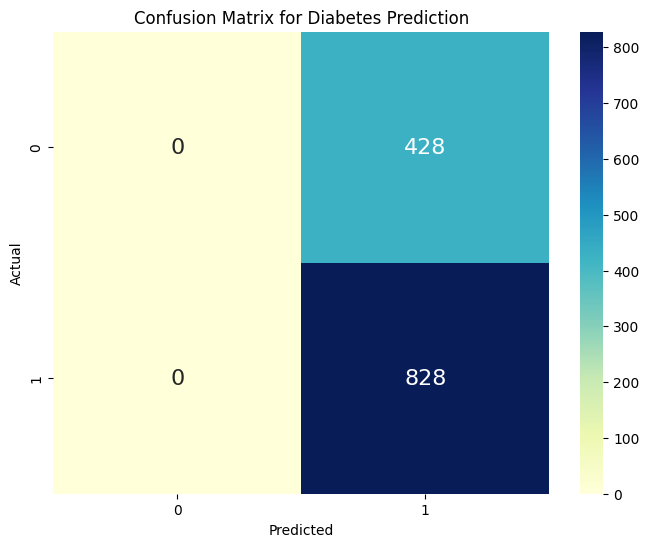

In [664]:
# Get the confusion matrix
conf_matrix_diab = confusion_matrix(y_test_diab, y_pred_diab)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_diab, annot=True, cmap="YlGnBu", fmt='g', annot_kws={"size": 16})

# Adding labels, title, and ticks
plt.title('Confusion Matrix for Diabetes Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [665]:
accuracy_obesity = accuracy_score(y_test_obesity, y_pred_obesity)
precision_obesity = precision_score(y_test_obesity, y_pred_obesity)
recall_obesity = recall_score(y_test_obesity, y_pred_obesity)
f1_obesity = f1_score(y_test_obesity, y_pred_obesity)

# Print evaluation metrics
print('Metrics for Obesity Feature')
print("Accuracy:", accuracy_obesity)
print("Precision:", precision_obesity)
print("Recall:", recall_obesity)
print("F1 Score:", f1_obesity)

print(y_pred_obesity[0:9])

Metrics for Obesity Feature
Accuracy: 0.4864649681528662
Precision: 0.4864649681528662
Recall: 1.0
F1 Score: 0.6545259775040172
[1 1 1 1 1 1 1 1 1]


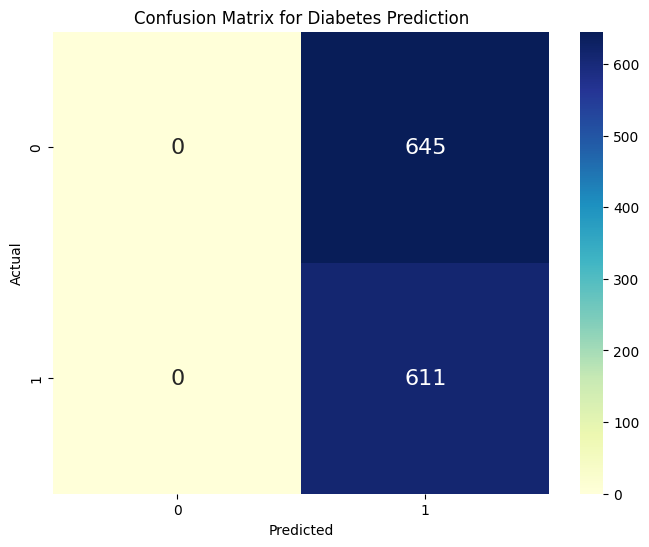

In [666]:
# Get the confusion matrix
conf_matrix_obesity = confusion_matrix(y_test_obesity, y_pred_obesity)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_obesity, annot=True, cmap="YlGnBu", fmt='g', annot_kws={"size": 16})

# Adding labels, title, and ticks
plt.title('Confusion Matrix for Diabetes Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [667]:
accuracy_famHist = accuracy_score(y_test_famHist, y_pred_famHist)
precision_famHist = precision_score(y_test_famHist, y_pred_famHist)
recall_famHist = recall_score(y_test_famHist, y_pred_famHist)
f1_famHist = f1_score(y_test_famHist, y_pred_famHist)

# Print evaluation metrics
print('Metrics for Obesity Feature')
print("Accuracy:", accuracy_famHist)
print("Precision:", precision_famHist)
print("Recall:", recall_famHist)
print("F1 Score:", f1_famHist)

print(y_pred_famHist[0:9])

Metrics for Obesity Feature
Accuracy: 0.49920382165605093
Precision: 0.49920382165605093
Recall: 1.0
F1 Score: 0.6659585767392459
[1 1 1 1 1 1 1 1 1]


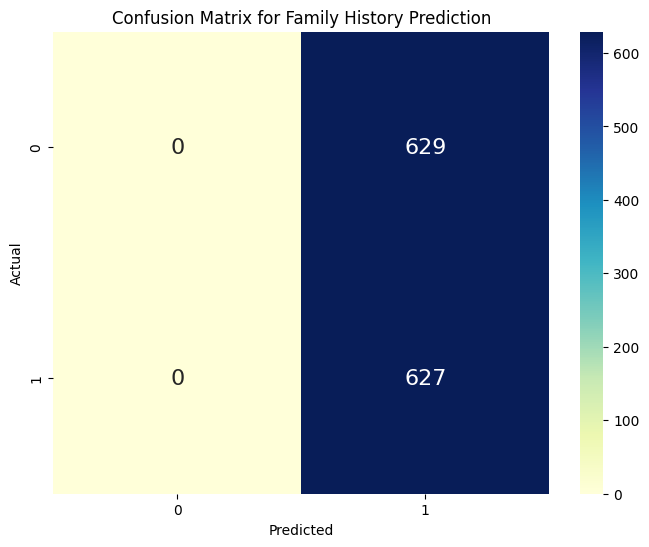

In [668]:
# Get the confusion matrix
conf_matrix_famHist = confusion_matrix(y_test_famHist, y_pred_famHist)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_famHist, annot=True, cmap="YlGnBu", fmt='g', annot_kws={"size": 16})

# Adding labels, title, and ticks
plt.title('Confusion Matrix for Family History Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [669]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Data/Heart Risk Combined Final Dataset.csv"

dataset = pd.read_csv(file_path)

dataset.head()

,Age,Sex,Blood Pressure,Cholesterol,Heart Risk,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,40,M,140,289,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49,F,160,180,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,M,130,283,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48,F,138,214,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54,M,150,195,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [670]:
dataset['Sex'] = dataset[['Sex']].apply(gender_map)
dataset['Hemisphere'] = dataset[['Hemisphere']].apply(hemisphere_map)
dataset['Country'] = dataset[['Country']].apply(countries_map)
dataset['Diet'] = dataset[['Diet']].apply(diet_map)
dataset['Continent'] = dataset[['Continent']].apply(continent_map)

dataset.head()

,Age,Sex,Blood Pressure,Cholesterol,Heart Risk,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,40,1,140,289,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49,0,160,180,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,1,130,283,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48,0,138,214,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54,1,150,195,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [671]:
# Assume you have a pre-trained logistic regression model named 'logistic_regression_model'

# 1
def fill_missing_diab(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4] # Select only the first five columns as features because they are the shared features
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_obesity(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_famHist(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_smoking(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

# 5
def fill_missing_alcCon(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_hr(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_ExHrsPrWk(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_diet(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_previousHeartProb(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

#10
def fill_missing_medUse(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_stressLvl(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_sedHrs(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_income(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_bmi(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

#15
def fill_missing_trig(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_phyDays(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_sleepHrs(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_country(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_continent(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

def fill_missing_hemis(dataset, column_name, trained_model):
    for idx, row in dataset.iterrows():
        if pd.isnull(row[column_name]):
            # Select all non-NaN values in the row
            features = row.iloc[:4]
            # Stack a '1' at the beginning of the resulting vector
            features = np.hstack(([1], features))
            features_array = features.reshape(1, -1)  # Reshape as a 2D array for prediction
            predicted_value = trained_model.predict(features_array)[0]
            dataset.at[idx, column_name] = predicted_value

In [672]:
# Replace 'Your_Column_Name' with the column name to be filled
fill_col_diab = 'Diabetes'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_diab(dataset, fill_col_diab, logistic_diab)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_obesity = 'Obesity'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_obesity(dataset, fill_col_obesity, logistic_obesity)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_alcCon = 'Alcohol Consumption'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_alcCon(dataset, fill_col_alcCon, logistic_alcCon)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_ExHrsPrWk = 'Exercise Hours Per Week'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_ExHrsPrWk(dataset, fill_col_ExHrsPrWk, linear_ExHrsPrWk)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_diet = 'Diet'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_diet(dataset, fill_col_diet, log_multi_diet)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_previousHeartProb = 'Previous Heart Problems'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_previousHeartProb(dataset, fill_col_previousHeartProb, logistic_previousHeartProb)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_continent = 'Continent'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_continent(dataset, fill_col_continent, log_multi_continent)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_hr = 'Heart Rate'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_hr(dataset, fill_col_hr, linear_hr)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_famHist = 'Family History'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_famHist(dataset, fill_col_famHist, logistic_famHist)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_smoking = 'Smoking'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_smoking(dataset, fill_col_smoking, logistic_smoking)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_hemis = 'Hemisphere'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_hemis(dataset, fill_col_hemis, logistic_hemis)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_medUse = 'Medication Use'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_medUse(dataset, fill_col_medUse, logistic_medUse)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_stressLvl = 'Stress Level'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_stressLvl(dataset, fill_col_stressLvl, log_multi_stressLvl)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_sedHrs = 'Sedentary Hours Per Day'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_sedHrs(dataset, fill_col_sedHrs, linear_sedHrs)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_income = 'Income'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_income(dataset, fill_col_income, linear_income)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_bmi = 'BMI'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_bmi(dataset, fill_col_bmi, linear_bmi)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_trig = 'Triglycerides'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_trig(dataset, fill_col_trig, linear_trig)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_phyDays = 'Physical Activity Days Per Week'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_phyDays(dataset, fill_col_phyDays, log_multi_phyDays)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_sleepHrs = 'Sleep Hours Per Day'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_sleepHrs(dataset, fill_col_sleepHrs, log_multi_sleepHrs)

# Replace 'Your_Column_Name' with the column name to be filled
fill_col_country = 'Country'
# Replace 'logistic_regression_model' with your pre-trained logistic regression model
fill_missing_country(dataset, fill_col_country, log_multi_country)

dataset.head()

,Age,Sex,Blood Pressure,Cholesterol,Heart Risk,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere
0,40,1,140,289,0,304.342082,1.0,1.0,1.0,1.0,...,5.0,304.342082,304.342082,304.342082,304.342082,5.0,5.0,5.0,5.0,1.0
1,49,0,160,180,1,425.888148,1.0,1.0,1.0,1.0,...,7.0,425.888148,425.888148,425.888148,425.888148,7.0,7.0,7.0,7.0,1.0
2,37,1,130,283,0,299.019353,1.0,1.0,1.0,1.0,...,5.0,299.019353,299.019353,299.019353,299.019353,5.0,5.0,5.0,5.0,1.0
3,48,0,138,214,1,375.511197,1.0,1.0,1.0,1.0,...,5.0,375.511197,375.511197,375.511197,375.511197,5.0,5.0,5.0,5.0,1.0
4,54,1,150,195,0,408.567916,1.0,1.0,1.0,1.0,...,5.0,408.567916,408.567916,408.567916,408.567916,5.0,5.0,5.0,5.0,1.0


In [673]:
path_to_save = '/content/drive/MyDrive/Colab_Notebooks/Data/Processed Combined Final Dataset.csv'
dataset.to_csv(path_to_save, index=False)